# Quantifying Taylor Swift's Pen-Themed Songwriting Approach

## Introduction

During her [acceptance speech](https://www.youtube.com/watch?v=lIrHts62ACQ&t=122s) for the Innovator Award at the 2023 iHeartRadio Music Awards, Taylor Swift stated that people in any industry often look for a precedent or data that shows that an idea is good or feasible; that is, an example of something working before. However, she believes that the "the coolest ideas or moves or choices are the new ones, the ones that set a new precedent."

Inspired by this statement as well as my observations of Swift's impact on music and popular culture, I decided to take a deep dive into her past work and use various inferential approaches to uncover potentially interesting patterns. In this analysis, I am using the [audio features](https://developer.spotify.com/documentation/web-api/reference/get-audio-features) data from her official Spotify account as well as the lyrics of her songs according to Genius. To narrow down the scope of the analysis, I am only considering her 10 original studio albums, along with the deluxe tracks, but excluding any alternative versions (acoustic versions, demos, live performances, etc.). The goals of the project are broad, but in general I am interested in gaining insight from her lyrics and building a classifier for what Swift has described as three pen types for her writing process (quill, fountain pen, glitter gel pen). More about these definitions can be found in [this](https://www.hollywoodreporter.com/news/music-news/taylor-swift-songwriting-process-nashville-speech-1235224700/) article by *The Hollywood Reporter*.

Previous efforts have been done to examine Swift's discography using various data-driven approaches. Thus, my hope is to expand on such type of research by applying some of the methods to her most up-to-date discography and contribute with useful information, especially in the area of Swift's pen-themed approach to songwriting. Given that the said approach is not officially recognized and is rather based on loose definitions that are unique to Swift's craft, it is intriguing to explore how Swift's pen style is applied to her music and if it could be explained in more commonly accepted terms.

It should be acknowledged that this research is limited in many ways. From the features to the methods I have selected, the project can hardly touch upon all of the aural and lyrical complexities that differentiate Swift from other musical acts. Moreover, this analysis treats Swift's music in isolation from her status as a pop sensation and does not consider how her media presence might impact the nature of her work. Nevertheless, the analysis presented below is a good starting point to a greater endeavor of learning about the specifics of Taylor Swift's music.

## Data Collection and Cleaning

First, we are going to gather and preprocess the data that we will need for our analysis. The full code can be found below.

### Scrape Taylor Swift's Spotify data

In [85]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    import chardet
    import matplotlib.pyplot as plt
    import nltk
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    from nltk.stem import PorterStemmer
    from nrclex import NRCLex
    import numpy as np
    import pandas as pd
    import seaborn as sns
    from sklearn.decomposition import PCA
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    from sklearn.preprocessing import StandardScaler
    from sklearn.tree import DecisionTreeClassifier, export_text
    import spotipy
    from spotipy.oauth2 import SpotifyClientCredentials
    from textblob import TextBlob
    import warnings

In [3]:
client_id = "1a4b9b996ce44425beea7a5cd8b9c4ff"
client_secret = "1e1d17e585324ac5a348cdff27ff0a83"

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

artist_id = "06HL4z0CvFAxyc27GXpf02"

def get_artist_tracks_with_info(artist_id, starting_offset):
    all_tracks = []
    offset = starting_offset

    while True:
        albums = sp.artist_albums(artist_id, album_type='album', offset=offset)

        if not albums['items']:
            break

        for album in albums['items']:
            album_id = album['id']
            tracks = sp.album_tracks(album_id)

            for item in tracks['items']:
                track_info = sp.track(item['id'])
                audio_features = sp.audio_features(item['id'])

                if audio_features:
                    audio_features = audio_features[0]
                else:
                    audio_features = {}

                all_tracks.append({
                    "track_name": track_info['name'],
                    "album_name": track_info['album']['name'],
                    "album_release_date": track_info['album']['release_date'],
                    "album_release_year": track_info['album']['release_date'][:4],
                    "danceability": audio_features.get('danceability', None),
                    "energy": audio_features.get('energy', None),
                    "key": audio_features.get('key', None),
                    "loudness": audio_features.get('loudness', None),
                    "mode": audio_features.get('mode', None),
                    "speechiness": audio_features.get('speechiness', None),
                    "acousticness": audio_features.get('acousticness', None),
                    "instrumentalness": audio_features.get('instrumentalness', None),
                    "liveness": audio_features.get('liveness', None),
                    "valence": audio_features.get('valence', None),
                    "tempo": audio_features.get('tempo', None),
                    "time_signature": audio_features.get('time_signature', None),
                    "duration_ms": track_info['duration_ms'],
                    "explicit": track_info.get('explicit', None)
                })

        offset += len(albums['items'])

    return all_tracks

taylorswift = pd.DataFrame(get_artist_tracks_with_info(artist_id, 0))

### Select all unique songs from the original studio albums

This selection captures a clean presentation of Swift's discography, thereby excluding only live performances, alternative versions (e.g. remixes, demos, etc.), previously unreleased songs (also known as "vault tracks") as well as songs that were not part of any of her studio albums (e.g. "I Don’t Wanna Live Forever").

First, an initial filtering will be done by selecting the most complete versions of each album, as shown below: 

In [4]:
album_names_to_keep = [
    "Midnights (The Til Dawn Edition)",
    "evermore (deluxe version)",
    "folklore (deluxe version)",
    "Lover",
    "reputation",
    "1989 (Deluxe)",
    "Red (Deluxe Edition)",
    "Speak Now (Deluxe Package)",
    "Fearless (Platinum Edition)",
    "Taylor Swift"
]

taylorswift = taylorswift[taylorswift['album_name'].isin(album_names_to_keep)]
taylorswift.reset_index(drop = True, inplace = True)

The duplicate tracks will be now removed from each album:

In [5]:
# Remove "Snow On The Beach (feat. More Lana Del Rey) and "Karma (feat. Ice Spice)" from "Midnights"
taylorswift = taylorswift.drop([21, 22], axis = 0)
taylorswift.reset_index(drop = True, inplace = True)

In [6]:
# Remove the voice memos from "1989"
taylorswift = taylorswift.drop([104, 105, 106], axis = 0)
taylorswift.reset_index(drop = True, inplace = True)

In [7]:
# Remove original demo recordings and "State Of Grace - Acoustic" from "Red"
taylorswift = taylorswift.drop([123, 124, 125], axis = 0)
taylorswift.reset_index(drop = True, inplace = True)

In [8]:
# Remove the acoustic and alternative versions of 
# "Mine," "Back to December," "The Story of Us," and "Haunted"
taylorswift = taylorswift.drop([140, 141, 142, 143, 144], axis = 0)
taylorswift.reset_index(drop = True, inplace = True)

In [9]:
# Remove "Untouchable" since it is a cover
# Remove "Forever & Always - Piano Version" from "Fearless"
taylorswift = taylorswift.drop([141, 142], axis = 0)
taylorswift.reset_index(drop = True, inplace = True)

In [10]:
# Remove "Teardrops on My Guitar - Pop Version" from "Taylor Swift"
taylorswift = taylorswift.drop(171, axis = 0)
taylorswift.reset_index(drop = True, inplace = True)

Even though some of these songs are part of the deluxe versions of the albums, the album names will be shortened for convenience so as to represent the "musical era" that a track belongs to.

In [11]:
taylorswift.loc[taylorswift['album_name'] == "Midnights (The Til Dawn Edition)", 'album_name'] = "Midnights"
taylorswift.loc[taylorswift['album_name'] == "evermore (deluxe version)", 'album_name'] = "evermore"
taylorswift.loc[taylorswift['album_name'] == "folklore (deluxe version)", 'album_name'] = "folklore"
taylorswift.loc[taylorswift['album_name'] == "1989 (Deluxe)", 'album_name'] = "1989"
taylorswift.loc[taylorswift['album_name'] == "Red (Deluxe Edition)", 'album_name'] = "Red"
taylorswift.loc[taylorswift['album_name'] == "Speak Now (Deluxe Package)", 'album_name'] = "Speak Now"
taylorswift.loc[taylorswift['album_name'] == "Fearless (Platinum Edition)", 'album_name'] = "Fearless"

### Extract the lyrics for each song

The lyrics for the tracks in `taylorswift` will be used as another field to characterize Swift's discography.

In [12]:
with open("D:/Users/valeri.vankov/Downloads/Taylor_Swift_Genius_Data.csv", 'rb') as file:
    result = chardet.detect(file.read())

taylorswift['lyrics'] = pd.read_csv("D:/Users/valeri.vankov/Downloads/Taylor_Swift_Genius_Data.csv", 
                                    encoding = result['encoding'])['Lyrics']
taylorswift['lyrics'] = taylorswift['lyrics'].replace('\n', ' ', regex = True)

### Clear the row names and make the quantitative variables numeric

In [13]:
taylorswift.reset_index(drop = True, inplace = True)
for i in range(5, 18):
    taylorswift.iloc[:, i] = pd.to_numeric(taylorswift.iloc[:, i], errors = 'coerce')

### Add pen types

This classification is based on the results of a [poll](https://www.reddit.com/r/TaylorSwift/comments/xoc8qm/results_playlists_quill_fountain_pen_or_glitter/) that was responsed by around 500 Taylor Swift fans (also known as "Swifties"). Given the disproportionate amount of songs that the fans classified as "fountain pen" compared to "quill" and "glitter gel pen," the creators of the poll decided to create their own Spotify playlists which allocate some of the fountain pen songs to the other two categories:

In [14]:
taylorswift['pen'] = None

In [15]:
# Fountain pen songs
fountain_pen = sp.playlist_tracks("1Yf6Seg9lzZU4sqxqfekBw")['items']
fountain_pen = [track['track']['name'] for track in fountain_pen]
fountain_pen = [s.replace("(Taylor’s Version)", "").replace("(Taylor's Version)", "").strip() for s in fountain_pen]
fountain_pen[2] = "Teardrops On My Guitar - Radio Single Remix"
fountain_pen[31] = "The Last Time"
fountain_pen[33] = "Everything Has Changed"

In [16]:
# Quill songs
quill = sp.playlist_tracks("6MGHHVP4yRFChABnQTHS9Q")['items']
quill = [track['track']['name'] for track in quill]
quill = [s.replace("(Taylor’s Version)", "").replace("(Taylor's Version)", "").strip() for s in quill]

In [17]:
# Glitter gel pen songs
glitter_gel_pen = sp.playlist_tracks("1IFexfQzNRySsZwlYfpR2v")['items']
glitter_gel_pen = [track['track']['name'] for track in glitter_gel_pen]
glitter_gel_pen = [s.replace(
    "(Taylor’s Version)", "").replace(
        "(Taylor's Version)", "").strip() for s in glitter_gel_pen]
glitter_gel_pen[16] = "I Knew You Were Trouble."

In [18]:
taylorswift.loc[taylorswift['track_name'].isin(fountain_pen), 'pen'] = "fountain pen"
taylorswift.loc[taylorswift['track_name'].isin(quill), 'pen'] = "quill"
taylorswift.loc[taylorswift['track_name'].isin(glitter_gel_pen), 'pen'] = "glitter gel pen"

add_tracks = ["Holy Ground", "Begin Again", "Mine - POP Mix", 
              "Never Grow Up", "SuperStar", "Breathe", "You're Not Sorry", "Stay Beautiful", 
              "I'm Only Me When I'm With You", "Invisible", "Cold As You", "A Perfectly Good Heart"]
taylorswift.loc[taylorswift['track_name'].isin(add_tracks), 'pen'] = "fountain pen"
taylorswift.loc[taylorswift['track_name'] == "Hits Different", 'pen'] = "glitter gel pen"
taylorswift.loc[taylorswift['track_name'] == "22", 'pen'] = "glitter gel pen"

As shown by the tables below, there are 75 fountain pen, 55 glitter gel pen, and 41 quill tracks, which comprise approximately 44, 32, and 24 percent of Swift's discography.

In [19]:
print("Frequency Table:")
print(taylorswift['pen'].value_counts())
print("\nRelative Frequencies:")
print( taylorswift['pen'].value_counts() / len(taylorswift))

Frequency Table:
pen
fountain pen       75
glitter gel pen    55
quill              41
Name: count, dtype: int64

Relative Frequencies:
pen
fountain pen       0.438596
glitter gel pen    0.321637
quill              0.239766
Name: count, dtype: float64


## Exploratory Data Analysis

First, we are going to display the distributions of pen types across albums:

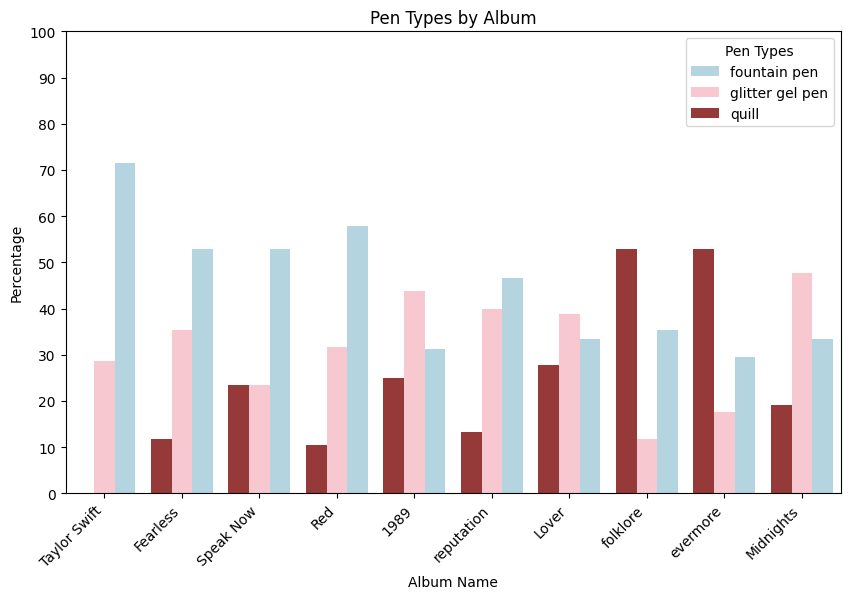

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    pen_distribution = taylorswift.groupby(['album_name', 'pen']).size().reset_index(name='count')
    pen_distribution['sum'] = pen_distribution.groupby('album_name')['count'].transform('sum')
    pen_distribution['percentage'] = (pen_distribution['count'] / pen_distribution['sum']) * 100
    order = taylorswift['album_name'].unique()
    pen_distribution['album_name'] = pd.Categorical(pen_distribution['album_name'], categories=order, ordered=True)
    pen_distribution = pen_distribution.sort_values(by='album_name')

    plt.figure(figsize=(10, 6))
    sns.barplot(x='album_name', y='percentage', hue='pen', data=pen_distribution, 
                palette={'fountain pen': 'lightblue', 'glitter gel pen': 'pink', 'quill': 'brown'})

    plt.title('Pen Types by Album')
    plt.xlabel('Album Name')
    plt.ylabel('Percentage')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Pen Types')
    plt.ylim(0, 100)
    plt.yticks(range(0, 101, 10))
    plt.gca().invert_xaxis()

There are a number of trends that could be observed from this mosaic plot. The percentage of fountain pen songs decreased after *Red* while the the percentage of quill tracks increased, reaching a noticeable peak during the *folklore* and *evermore* era. The percentage of glitter gel pen songs across albums is relatively consistent, with *Midnights* and *1989* having the highest percentage of glitter gel pen songs while *folklore* and *evermore*, followed by *Speak Now*, have the lowest percentage of such tracks. In other words, fountain pen songs predominated Swift's country era; glitter gel pen songs were the most popular throughout her pop eras; and quill songs were the most frequent in her indie eras. Thus, her songwriting approach is strongly dependent on the album and genre she is working with.

Next, we are going to create boxplots for the distributions of each of the pen types using the variables that cause the highest variability in the data. This can be done using principal components analysis (PCA). Before that, we are going to include two more categories: lexical diversity and sentiment score. To add those, we need to convert the dataset to a document-feature matrix.

In [21]:
# Tokenizing, removing punctuation, and stemming
porter = PorterStemmer()
stop_words = set(stopwords.words('english'))

def process_lyrics(lyrics):
    tokens = word_tokenize(lyrics)
    tokens = [word.lower() for word in tokens if word.isalpha() and word not in stop_words]
    tokens_stemmed = [porter.stem(word) for word in tokens]
    return ' '.join(tokens_stemmed)

# Creating a Document-Feature Matrix (DFM)
vectorizer = TfidfVectorizer()
taylorswift_dfm = pd.DataFrame(vectorizer.fit_transform(
    taylorswift['lyrics'].apply(process_lyrics)).toarray(), columns=vectorizer.get_feature_names_out())
taylorswift_dfm['track_name'] = taylorswift['track_name'].tolist()

Now we can add lexical diversity by calculating the type-token ratio (TTR) for the lyrics of each track.

In [212]:
for i in range(taylorswift.shape[0]):
    taylorswift['ttr'][i] = len(
        set(nltk.word_tokenize(taylorswift['lyrics'][i].lower()))) / len(
            nltk.word_tokenize(taylorswift['lyrics'][i].lower()))

We also add the sentiment score, whose value is above 0 if the overall sentiment of the lyrics is positive and below 0 if the sentiment is negative. In later sections we will conduct a more in-depth sentiment analysis.

In [101]:
def get_sentiment_polarity(text):
    analysis = TextBlob(text)
    return round(analysis.sentiment.polarity, 2)

taylorswift['sentiment'] = taylorswift['lyrics'].apply(get_sentiment_polarity)

Having these features as well, we are going to use PCA to see which ones account for the most variability in the dataset:

In [215]:
warnings.filterwarnings("ignore")

# Subsetting the continuous features
taylorswift_cont = taylorswift.iloc[:, [4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 20, 21]]

# Label encoding "explicit" as 0 or 1
taylorswift_cont['explicit'] = taylorswift_cont['explicit'].astype(int)

In [216]:
# Scaling the data
scaler = StandardScaler()
taylorswift_cont_scaled = scaler.fit_transform(taylorswift_cont)

# Applying PCA
pca = PCA()
taylorswift_cont_pca = pca.fit_transform(taylorswift_cont_scaled)

# Retrieving top 10 features
top_10_features = pd.DataFrame(
    pca.components_[0], 
    index=taylorswift_cont.columns).abs().sort_values(0, ascending=False).head(10)
print(top_10_features)

                         0
energy            0.486821
loudness          0.480124
acousticness      0.465897
ttr               0.299477
valence           0.297579
explicit          0.199938
liveness          0.170513
danceability      0.167951
instrumentalness  0.126719
duration_ms       0.106501


We are going to create plots for the top 5 features.

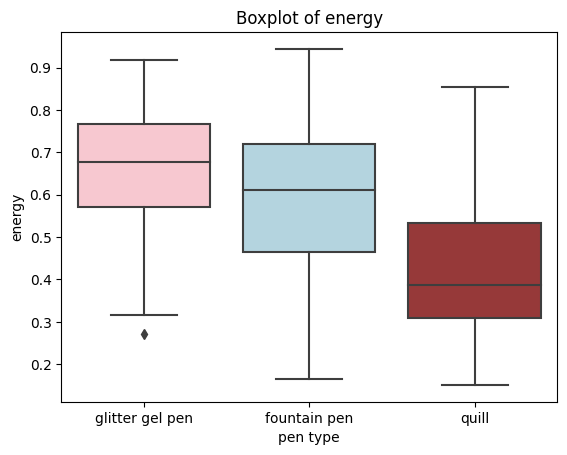

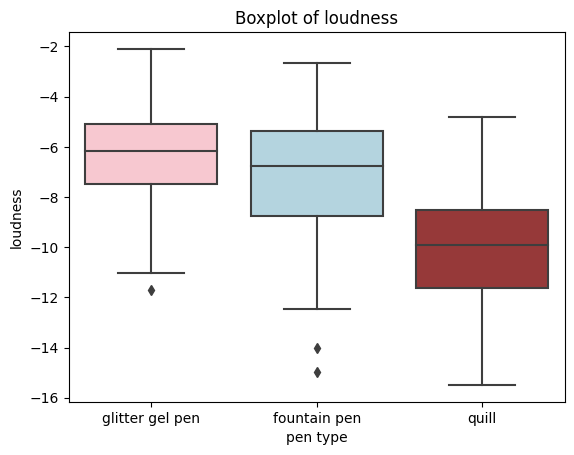

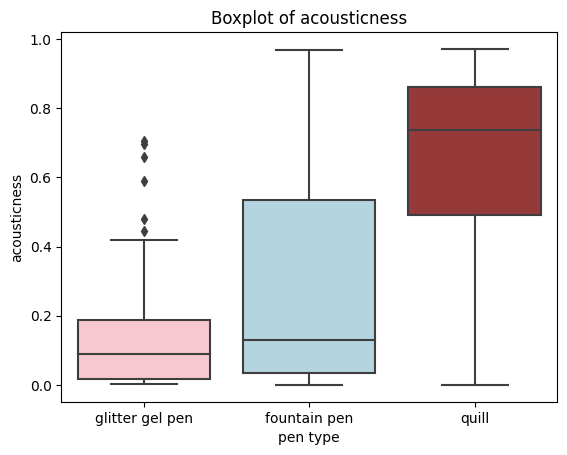

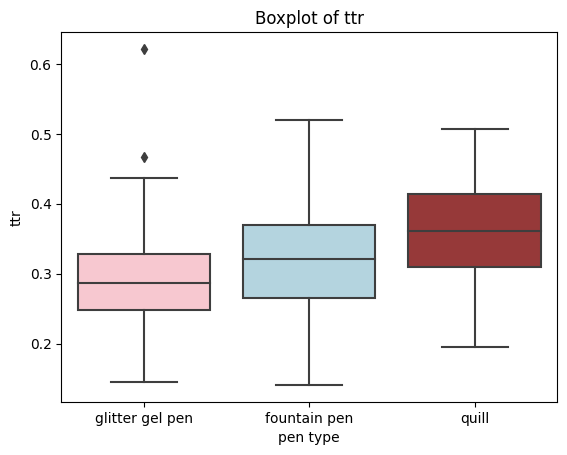

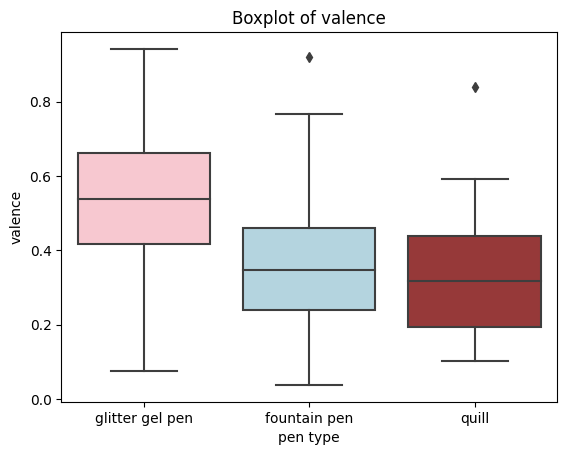

In [217]:
pen_colors = {'fountain pen': 'lightblue', 'glitter gel pen': 'pink', 'quill': 'brown'}

taylorswift_pca_vars = list(top_10_features.index[:5])

plot_list = []

for var in taylorswift_pca_vars:
    plt.figure()
    p = sns.boxplot(x='pen', y=taylorswift[var], data=taylorswift, palette=pen_colors)
    p.set(title=f'Boxplot of {var}', xlabel='pen type', ylabel=var)
    plot_list.append(p)

Based on the results from PCA, it seems that energy, loudness, acousticness, ttr, and valence are among the most important parameters in Swift's music given that they account for the most variability in the data. Interestingly, in all of these boxplot comparisons, fountain pen songs are in the "middle" between quill and glitter gel pen songs. This in part explains why it is difficult to make a distinction between the pen types and why many fans assigned certain songs to the "fountain pen" category. Glitter gel pen songs tend to have higher measures of energy, loudness, and valence, meaning that the instrumental usually aligns with the mood of the lyrics. At the same time, quill songs have higher acousticness and TTR scores, which suggests that Swift's slower and acoustic songs often have wider range of vocabulary as well. These different are especially highlighted by the music and albums in upbeat albums like *1989* versus mellow albums like *folklore* and *evermore*.

## Further Analysis

### Cosine Similarity for Lyrics

First, let's see what the most popular words in each pen type are:

We can check if the songs could be grouped by similarities in the frequency of words they use. We could do this by applying cosine similarity between all pairs of songs and choosing the most common label using k-Nearest Neighbors (kNN). The prior probability in each case (voted and balanced) will be the percentage of fountain pen songs (that is, if we were to label all songs as "fountain pen").

In [ ]:
def find_modes(x):
    unique_vals, counts = np.unique(x, return_counts=True)
    mode_vals = unique_vals[counts == np.max(counts)]
    return mode_vals

cos_sim_matrix = cosine_similarity(taylorswift_dfm.iloc[:, :2734], 
                                   taylorswift_dfm.iloc[:, :2734])

cos_sim_modes_list = []

# After increasing the number of neighbors,
# we find that the optimal number of neighbors is 2
for i in range(cos_sim_matrix.shape[0]):
    sim_scores = cos_sim_matrix[i]
    top_indices = np.argsort(sim_scores)[::-1][1:3]
    top_pens = taylorswift['pen'].iloc[top_indices].to_list()
    mode_pen = find_modes(top_pens)
    cos_sim_modes_list.append(mode_pen)

# Checking performance
p = 0

for i in range(taylorswift.shape[0]):
    if taylorswift['pen'].iloc[i] in cos_sim_modes_list[i]:
        p += 1
    if i == taylorswift.shape[0] - 1:
        print(f"pen error: {1 - p / taylorswift.shape[0]}")

print(f"prior probability: {np.mean(taylorswift['pen'] != 'fountain pen')}")

pen error: 0.41520467836257313
prior probability: 0.5614035087719298


In the best case scenario, the error is somewhat lower than the prior probability, showing that there is a slight distinction of the songs across pens based on the type and frequency of the vocabulary they use.

### Cosine Similarity for Lyric Sentiments

We are going to use a similar approach as in the previous section to perform sentiment analysis on the lyrics.

In [ ]:
ts_sentiment_detailed = taylorswift['lyrics'].apply(lambda x: NRCLex(x)).apply(lambda x: x.affect_frequencies)

Before that, we will plot the distributions of sentiments across pens:

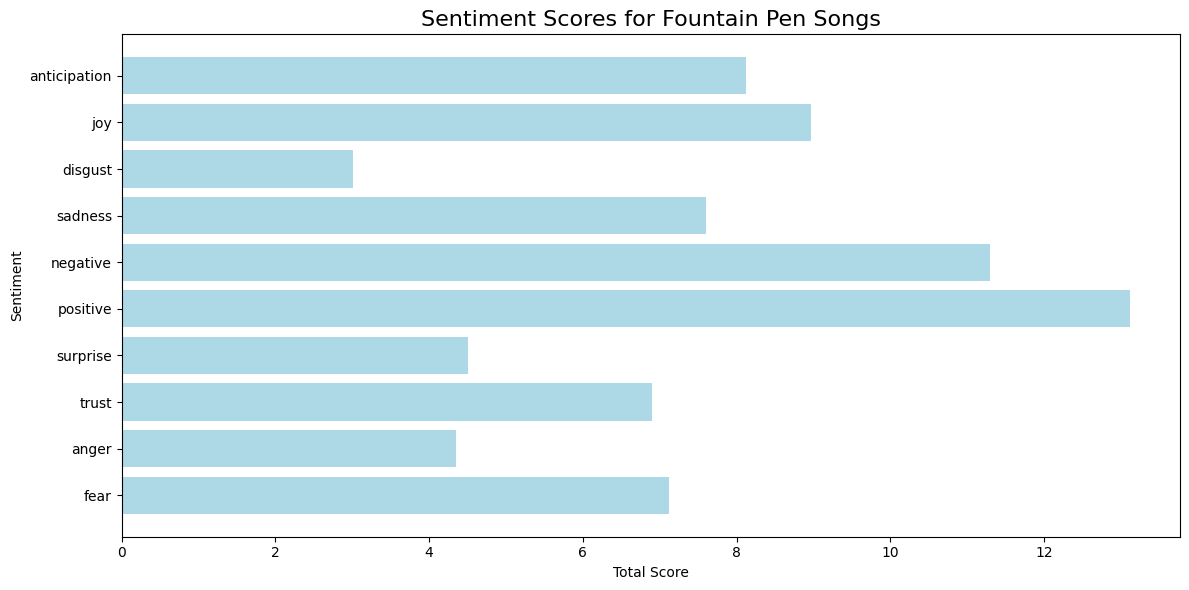

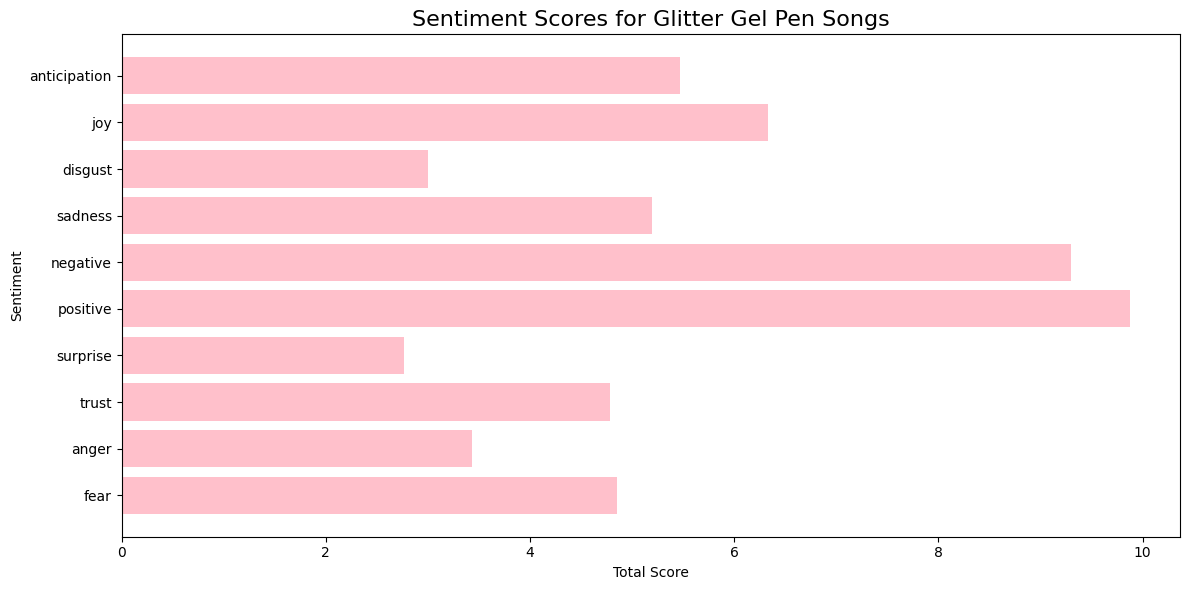

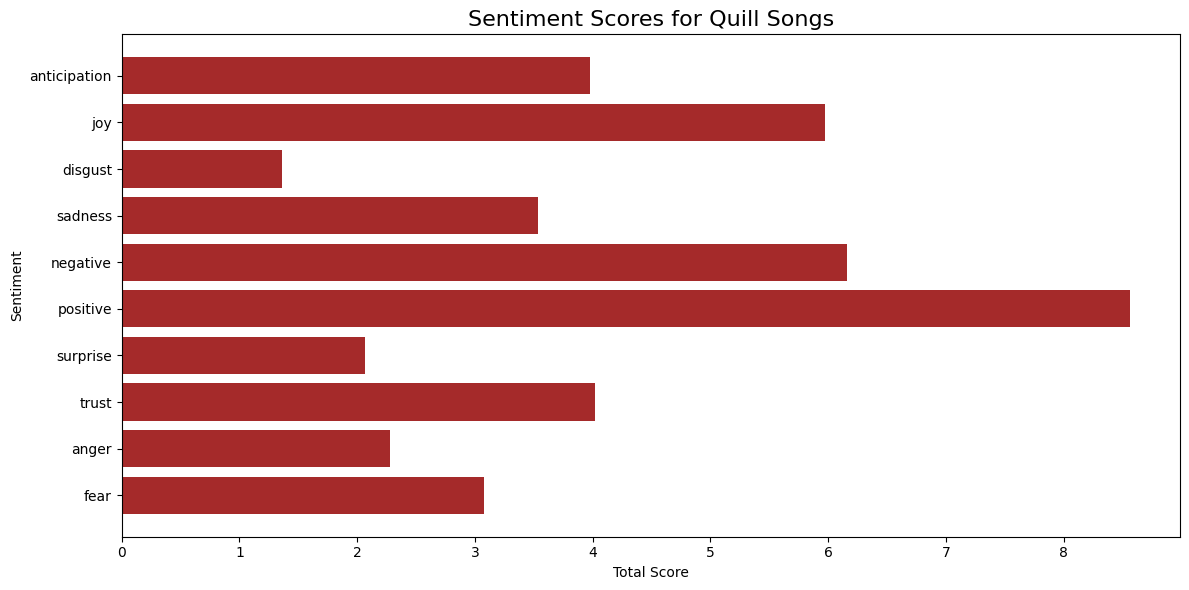

In [167]:
fountain_pen_sentiments = ts_sentiment_detailed[taylorswift['pen'] == 'fountain pen']
glitter_gel_pen_sentiments = ts_sentiment_detailed[taylorswift['pen'] == 'glitter gel pen']
quill_sentiments = ts_sentiment_detailed[taylorswift['pen'] == 'quill']

def create_aggregated_df(sentiments, pen_color, title):
    all_sentiments = pd.DataFrame(list(sentiments))
    all_sentiments = all_sentiments.drop(columns=['anticip'], errors='ignore')
    aggregated_scores = all_sentiments.sum()
    df = pd.DataFrame({'Sentiment': aggregated_scores.index, 'Total_Score': aggregated_scores.values})
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh(df['Sentiment'], df['Total_Score'], color=pen_color)
    ax.set_title(title, size=16)
    ax.set_xlabel('Total Score')
    ax.set_ylabel('Sentiment')
    plt.tight_layout()
    return df

fountain_pen_df = create_aggregated_df(fountain_pen_sentiments, 'lightblue', 'Sentiment Scores for Fountain Pen Songs')
glitter_gel_pen_df = create_aggregated_df(glitter_gel_pen_sentiments, 'pink', 'Sentiment Scores for Glitter Gel Pen Songs')
quill_df = create_aggregated_df(quill_sentiments, 'brown', 'Sentiment Scores for Quill Songs')

It is difficult to compare the three distributions because the number of songs in each pen type is different. However, we can notice that all three categories tend to have more "positive" than "negative" songs. The composition is sentiments is similar across pen types, with joy, anticipation, and trust being at the lead, followed by sadness and fear, and anger, disgust, and surprise at the bottom. It is evident that rather than having one or two predominating emotions, Swift's songs tend to employ a variety of sentiments not only in terms of her entire discography but also across all pen types. Therefore, pen types are not necessarily divided on the basis of sentiments only; instead, as seen above as well as in further detail below, they are influenced by the intricate ways in which the lyrics and underlying melodies are constructed.

We can proceed with the cosine similarity and kNN regression methods, which will inform us about the extent to which the songs from the same pen type can be categorized by similarities across their sentiment scores.

In [218]:
sentiment_values = ts_sentiment_detailed.apply(
    lambda x: np.array(list(x.values())).astype(float)).values

ts_sentiment_matrix = np.zeros((len(ts_sentiment_detailed), len(ts_sentiment_detailed)))

for i in range(len(ts_sentiment_detailed)):
    for j in range(len(ts_sentiment_detailed)):
        min_length = min(len(sentiment_values[i]), len(sentiment_values[j]))
        numerator = np.sum(sentiment_values[i][:min_length] * sentiment_values[j][:min_length])
        denominator = np.sqrt(
            np.sum(sentiment_values[i][:min_length]**2) * np.sum(
                sentiment_values[j][:min_length]**2))
        ts_sentiment_matrix[i, j] = np.arccos(numerator / denominator)

ts_sentiment_matrix[np.isnan(ts_sentiment_matrix)] = 0

sent_modes_list = []

for i in range(len(ts_sentiment_detailed)):
    sim_scores = ts_sentiment_matrix[i]
    top_indices = np.argsort(sim_scores)[::-1][1:3]
    top_pens = taylorswift['pen'].iloc[top_indices].to_list()
    mode_pen = find_modes(top_pens)
    sent_modes_list.append(mode_pen)

p = 0

for i in range(len(taylorswift)):
    if taylorswift['pen'].iloc[i] in sent_modes_list[i]:
        p += 1
    if i == len(taylorswift) - 1:
        print(f"pen error: {1 - p / len(taylorswift)}")

print(f"prior probability: {np.mean(taylorswift['pen'] != 'fountain pen')}")

pen error: 0.4385964912280702
prior probability: 0.5614035087719298


The error rate is much lower than the prior probability and this method seems to improve on the results from the word frequency comparison. Of course, this approach is by no means perfect, especially since more than a third of the songs are misclassified.

### Decision Trees

Finally, we are going to utilize classification decision trees, as they are fairly easy to interpret and are able to take multiple predictors into account. In this case, we do not need to prune the tree, as we want to be as detailed as possible about the distinctions between the pens.

#### Visualizing the tree

In [ ]:
taylorswift_cont = pd.concat([taylorswift['pen'], taylorswift_cont.iloc[:, 0:14]], axis=1)
taylorswift_cont.columns.values[0] = "pen"

taylorswift_cont['pen'] = pd.Categorical(taylorswift_cont['pen'])

tree = DecisionTreeClassifier(random_state=42)
X = taylorswift_cont.iloc[:, 1:]
y = taylorswift_cont['pen']
tree.fit(X, y)

In [111]:
tree_rules = export_text(tree, feature_names=list(X.columns))
print(tree_rules)

|--- acousticness <= 0.49
|   |--- danceability <= 0.60
|   |   |--- liveness <= 0.09
|   |   |   |--- class: quill
|   |   |--- liveness >  0.09
|   |   |   |--- mode <= 0.50
|   |   |   |   |--- danceability <= 0.55
|   |   |   |   |   |--- class: glitter gel pen
|   |   |   |   |--- danceability >  0.55
|   |   |   |   |   |--- acousticness <= 0.14
|   |   |   |   |   |   |--- class: fountain pen
|   |   |   |   |   |--- acousticness >  0.14
|   |   |   |   |   |   |--- class: quill
|   |   |   |--- mode >  0.50
|   |   |   |   |--- danceability <= 0.54
|   |   |   |   |   |--- class: fountain pen
|   |   |   |   |--- danceability >  0.54
|   |   |   |   |   |--- energy <= 0.47
|   |   |   |   |   |   |--- class: quill
|   |   |   |   |   |--- energy >  0.47
|   |   |   |   |   |   |--- loudness <= -4.29
|   |   |   |   |   |   |   |--- danceability <= 0.55
|   |   |   |   |   |   |   |   |--- class: quill
|   |   |   |   |   |   |   |--- danceability >  0.55
|   |   |   |   |   |  

In this tree diagram each split partitions the songs into smaller sets until a label (in this case, a pen type) is returned. The left branch follows the rule described by the internal node while the right branch follows the opposite rule. For example, the branch to the left of "acousticness $\le$ 0.49" describes songs with acousticness that does not exceed 0.49 while the branch to the right describes songs whose acousticness is above 0.49. In general, though, it is clear that this diagram is very convoluted and requires multiple predictors to classify the songs. Moreover, the model is fit to Swift's current catalogue and assumes that her musical approaches would not change significantly in the future.

## Conclusion

To summarize, we explored a number of ways to analyze Taylor Swift's music and were able, to some extent, quantify the pen types that she uses in her writing process. It would be interesting to consider how these models can be further improved and if they could be applied well to Swift's future releases.